# Purpose

Of this notebook is to create a new demo video from an actual in-store footage.

In [53]:
import os

%matplotlib notebook
import matplotlib.pyplot as plt

from IPython.display import Image, display

### Planogram


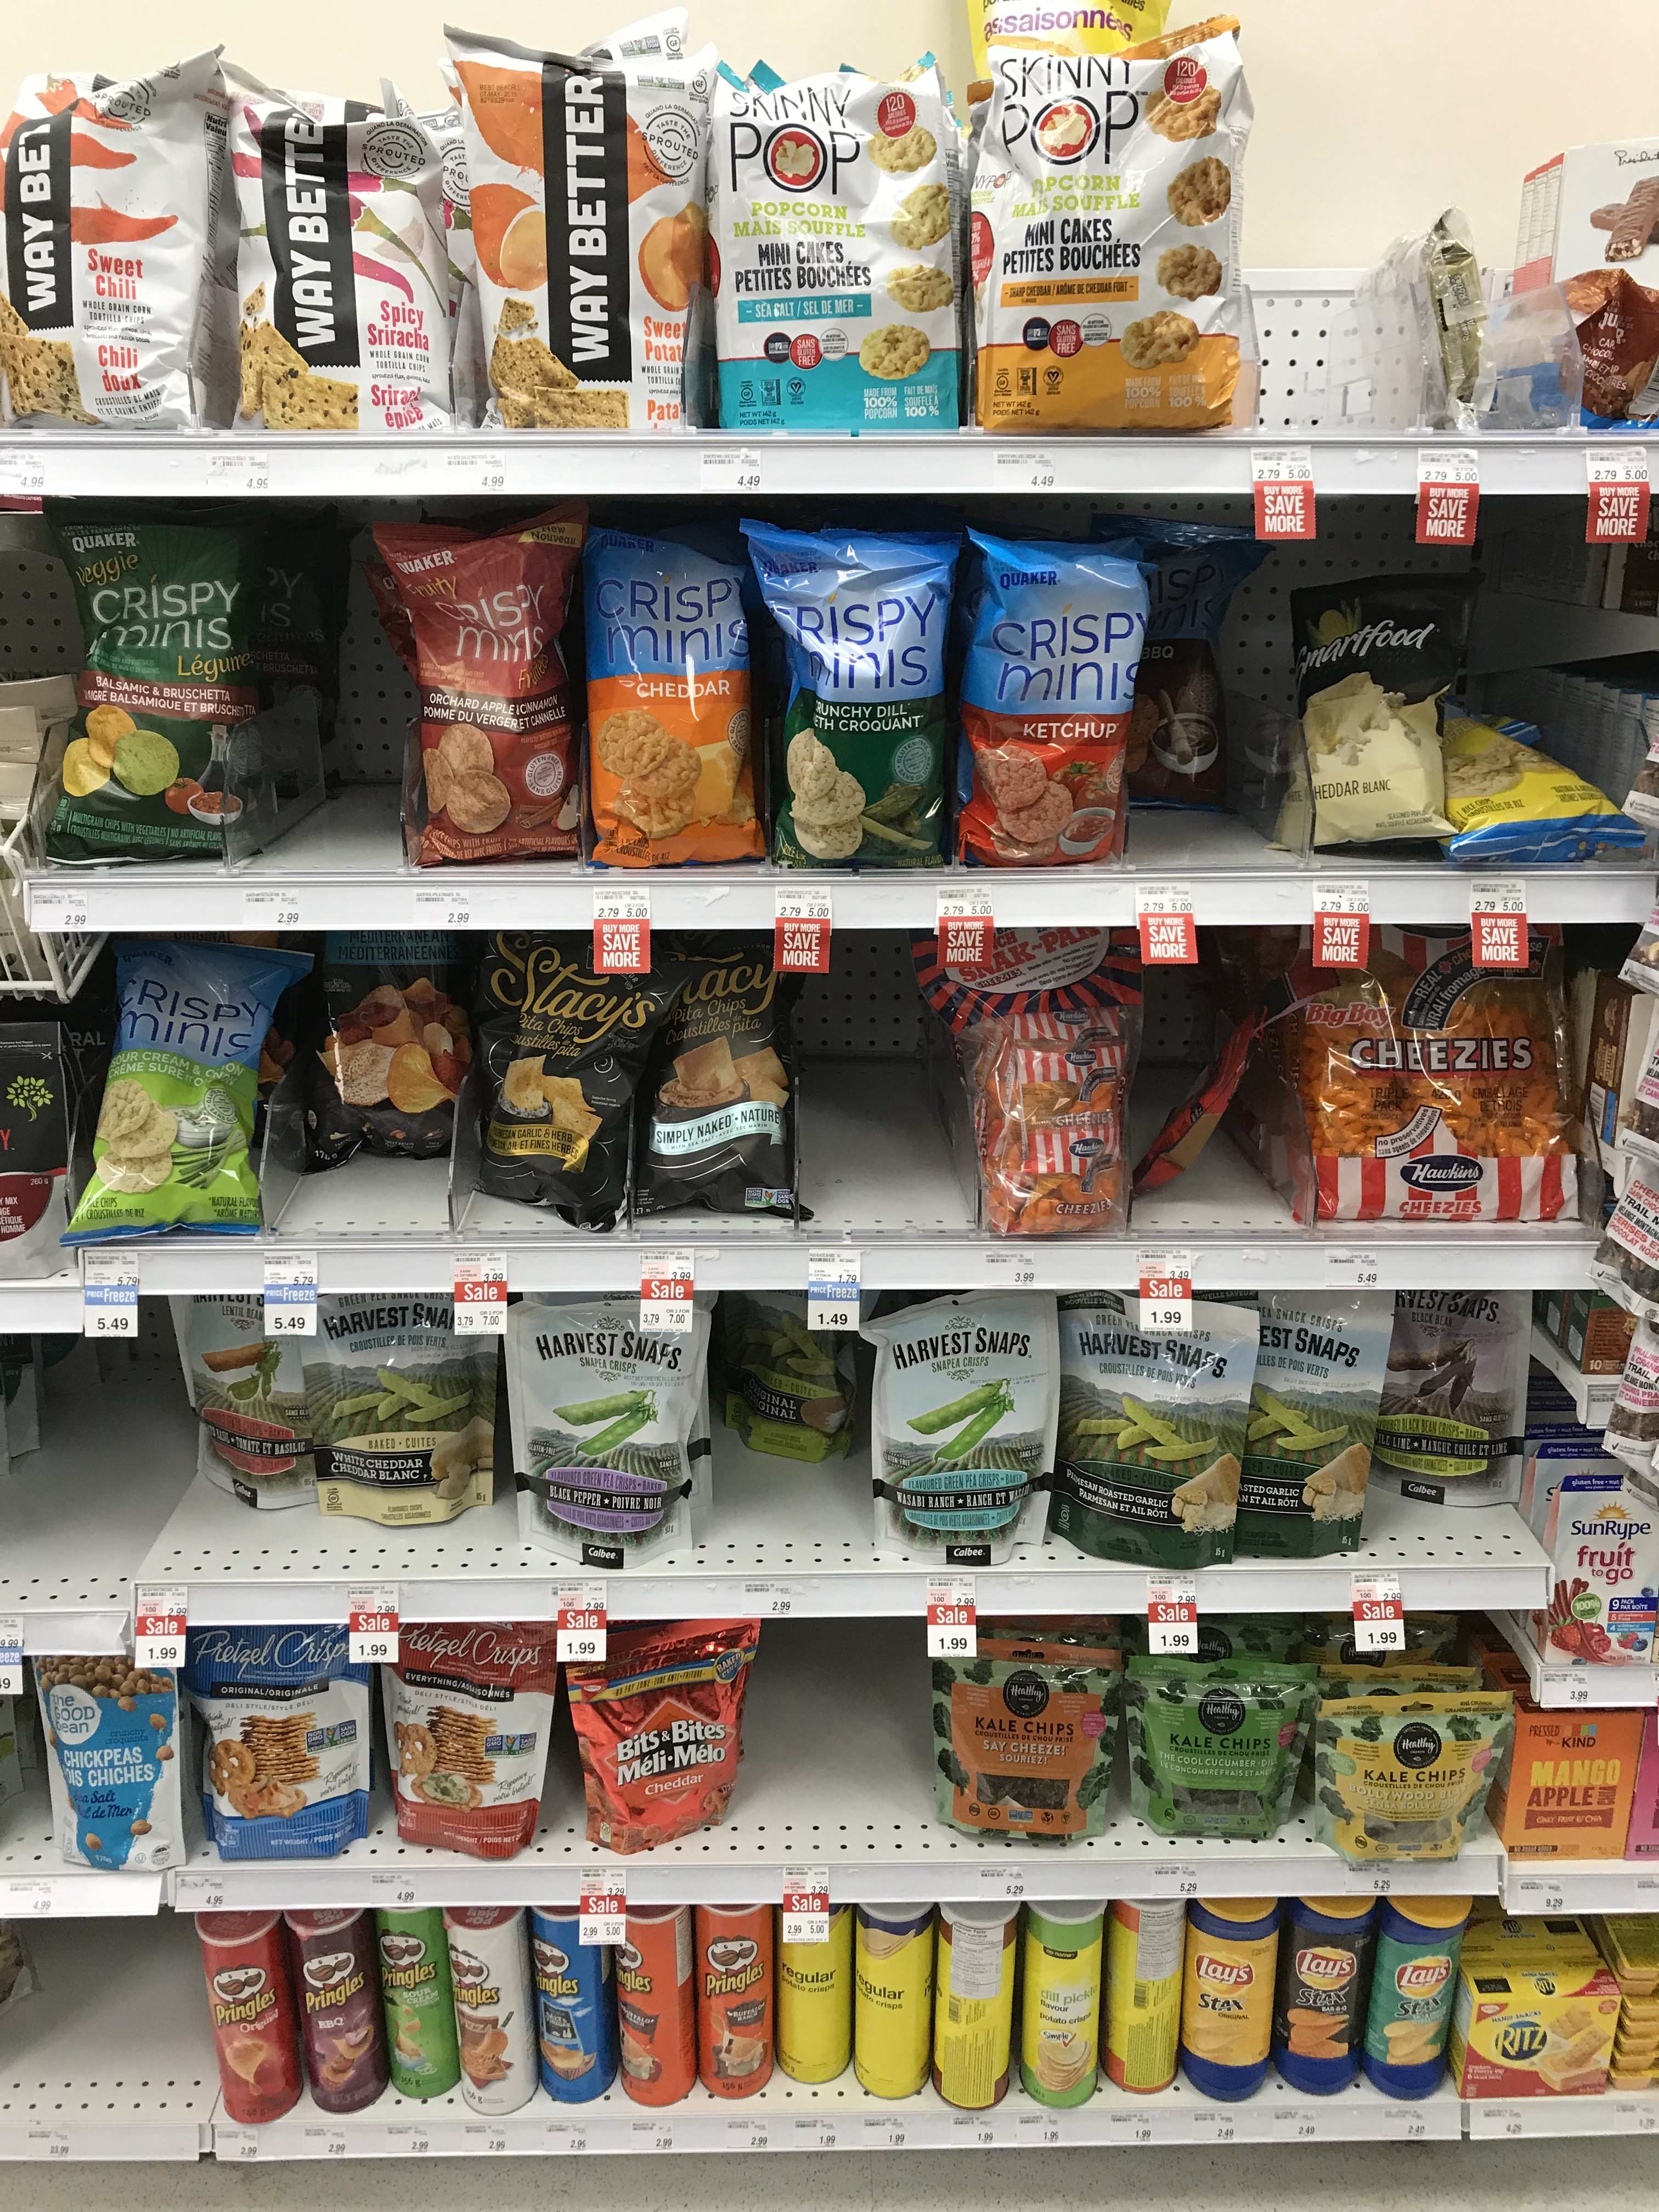

In [54]:
i = Image(filename='data_for_demo_v2/IMG_1978.jpg', width=500)
display(i)

Top shelf:
* Way Better Sweet Chili
* Way Better Spicy Sriracha
* Way Better Sweet Potato
* Skinny Pop Popcorn Sea Salt
* Skinny Pop Popcorn Sharp Cheddar

2nd shelf:
* Quaker Crispy Minis Balsamic & Bruschetta
* Quaker Crispy Minis Orchard Apple Cinnamon
* Quaker Crispy Minis Cheddar
* Quaker Crispy Minis Crunchy Dill
* Quaker Crispy Minis Ketchup
* Quaker Crispy Minis Cheddar
* Quaker Crispy Minis BBQ
* Smartfood White Cheddar

3rd shelf:
* Quaker Crispy Minis Sour Cream & Onion
* Mediterranean
* Stacy's Pita Chips Parmesan Garlic & Herb
* Stacy's Pita Chips Regular
* Big Boy Cheezies

4th shelf:
* Harvest Snap Tomato Basil
* Harvest Snap White Cheddar
* Harvest Snap Black Pepper
* Harvest Snap Original
* Harvest Snap Wasabi Ranch
* Harvest Snap Parmesan Roasted Garlic

5th shelf:
* Pretzel Crisps Original
* Pretzel Crisps Everything
* Bits & Bites Cheddar
* Kale Chips Say Cheese!
* Kale Chips The Cool Cucumber
* Kale Chips Bollywood Blast

### Original Video

In [55]:
DATA_DIR = 'data_for_demo_v2'
VENDNET_VIDEOS_DIR = 'vendnet'
VENDGAZE_VIDEOS_DIR = 'vendgaze'

ORIGINAL_VIDEO_FILENAME = 'shoppers-demo.mp4'
FACE_DETECTION_VIDEO_FILENAME = 'output-None.avi'
GAZE_DETECTION_VIDEO_FILENAME = 'output-test.avi'

FACE_BBOXES_FILENAME = 'video-det-fold-None.txt'
GAZE_ANGLES_FILENAME = 'output-test.txt'

ORIGINAL_VIDEO_PATH = os.path.join('..', 'data', ORIGINAL_VIDEO_FILENAME)
FACE_DETECTION_VIDEO_PATH = os.path.join(DATA_DIR, VENDNET_VIDEOS_DIR, FACE_DETECTION_VIDEO_FILENAME)
GAZE_DETECTION_VIDEO_PATH = os.path.join(DATA_DIR, VENDGAZE_VIDEOS_DIR, GAZE_DETECTION_VIDEO_FILENAME)
FACE_BBOXES_PATH = os.path.join(DATA_DIR, VENDNET_VIDEOS_DIR, FACE_BBOXES_FILENAME)
GAZE_ANGLES_PATH = os.path.join(DATA_DIR, VENDGAZE_VIDEOS_DIR, GAZE_ANGLES_FILENAME)

In [56]:
from moviepy.editor import *

In [57]:
# gaze_video = VideoFileClip(GAZE_DETECTION_VIDEO_PATH)
# gaze_video.ipython_display(width=500)

### Visualize Gaze

In [58]:
import pandas as pd
import numpy as np

In [59]:
bbox_df = pd.read_csv(FACE_BBOXES_PATH, delimiter='\t', header=None)
bbox_df.columns = ['frame_number', 'x_min', 'y_min', 'x_max', 'y_max', 'confidence_score']

In [60]:
len(bbox_df)

11480

In [61]:
bbox_df.head()

,frame_number,x_min,y_min,x_max,y_max,confidence_score
0,1,1152.87330,28.054468,1374.91690,304.964260,0.999905
1,1,378.32850,639.520750,410.95178,672.878970,0.970544
2,1,99.88773,0.000000,145.58276,36.165080,0.857674
3,1,545.99176,624.040800,582.78710,659.961850,0.463527
4,1,131.51338,0.000000,159.81853,27.508327,0.210578


In [62]:
gaze_df = pd.read_csv(GAZE_ANGLES_PATH, delimiter=' ', header=None)
gaze_df.columns = ['frame_number', 'x_angle', 'y_angle', 'z_angle']

In [63]:
len(gaze_df)

1009

In [64]:
gaze_df.tail()

,frame_number,x_angle,y_angle,z_angle
1004,1005,7.439621,-14.904907,7.401917
1005,1006,6.571350,-11.468094,7.233307
1006,1007,6.095078,-10.201653,8.862556
1007,1008,5.580780,-8.740143,8.995377
1008,1009,5.387650,-7.259239,8.381897


<IPython.core.display.Javascript object>


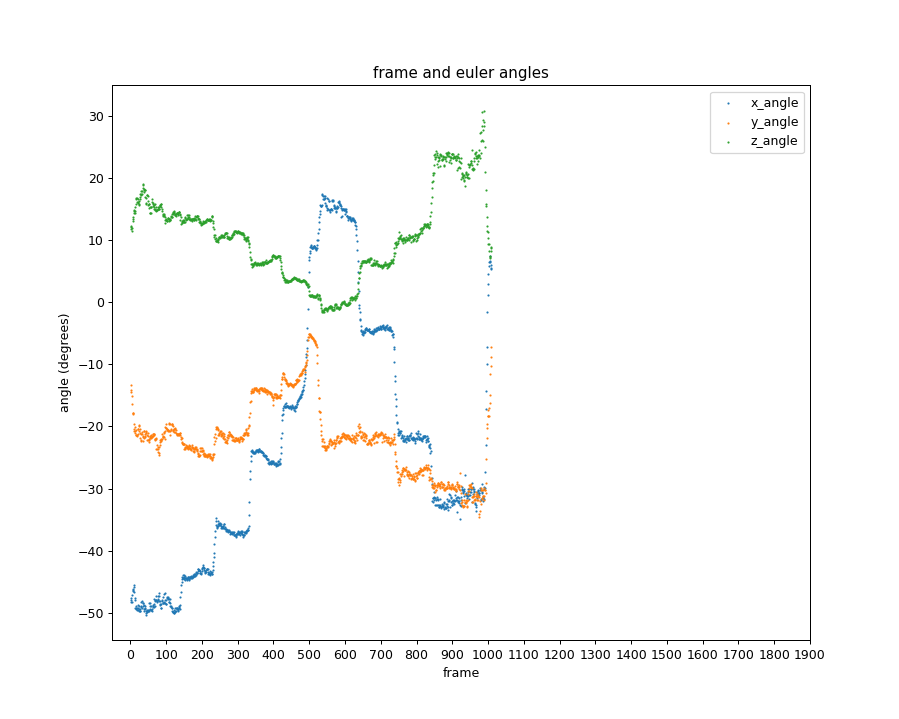

In [65]:
MARKER_SIZE = 0.5
FRAME_LIMIT = 2000

fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(111)

x = gaze_df.T.loc['frame_number'][:FRAME_LIMIT]
ax1.scatter(x, gaze_df.T.loc['x_angle'][:FRAME_LIMIT], s=MARKER_SIZE) # x angle
ax1.scatter(x, gaze_df.T.loc['y_angle'][:FRAME_LIMIT], s=MARKER_SIZE) # y angle
ax1.scatter(x, gaze_df.T.loc['z_angle'][:FRAME_LIMIT], s=MARKER_SIZE) # z angle

plt.title("frame and euler angles")
plt.xlabel("frame")
plt.ylabel("angle (degrees)")
plt.xticks(np.arange(0, FRAME_LIMIT, step=100))

plt.legend(["x_angle", "y_angle", "z_angle"])
fig.show()

In [75]:
TIME_MARKERS_SEC = [4, 7, 10, 15, 19, 21, 40, 35, 31, 27, 22]
TIME_MARKERS_FRAMES = [(24 * i) for i in TIME_MARKERS_SEC]

In [76]:
TIME_MARKERS_FRAMES

[96, 168, 240, 360, 456, 504, 960, 840, 744, 648, 528]

In [77]:
def calculate_rectangle_centroid(min_x, min_y, max_x, max_y):
    """
    Returns a tuple (x, y) which gives the position of the face bounding box.
    """
    return (min_x + max_x) / 2, (min_y + max_y) / 2  


def calculate_rectangle_area(min_x, min_y, max_x, max_y):
    """
    Returns the pixel area of the face bounding box.
    """
    return (max_x - min_x) * (max_y - min_y)

rect_centroids = []
rect_areas = []
gaze_x_angles = []
gaze_y_angles = []
gaze_z_angles = []

MAX_PADDING = 20

for frame in TIME_MARKERS_FRAMES:
    error = True
    print("frame", frame)
    
    # bbox
    # TODO: Take the average over the variance-bound frame interval
    bbox_coords = bbox_df.loc[bbox_df["frame_number"] == frame][['x_min', 'y_min', 'x_max', 'y_max']].as_matrix()[0]
    rect_centroid = calculate_rectangle_centroid(bbox_coords[0], bbox_coords[1], bbox_coords[2], bbox_coords[3])
    rect_area = calculate_rectangle_area(bbox_coords[0], bbox_coords[1], bbox_coords[2], bbox_coords[3])
    
    # gaze
    def get_average(angle, max_padding):
        padding = 1
        
        before = frame - padding <= gaze_df["frame_number"]
        after = gaze_df["frame_number"] <= frame + padding
        a = gaze_df.loc[after & before][angle].values
        
        # Variance-bound dynamic padding increments
        while a.var() <= 2.5 and padding < MAX_PADDING: # max variance setting
            padding += 1
            before = frame - padding <= gaze_df["frame_number"]
            after = gaze_df["frame_number"] <= frame + padding
            a = gaze_df.loc[after & before][angle].values
#             print(a.mean(), a.var())
        
        print("final padding:", padding)
        return a.mean()
    
    gaze_x_angle = get_average('x_angle', MAX_PADDING)
    gaze_y_angle = get_average('y_angle', MAX_PADDING)
    gaze_z_angle = get_average('z_angle', MAX_PADDING)
    #gaze_x_angle = gaze_df.loc[gaze_df["frame_number"] == frame]['x_angle'].values[0]
    #gaze_y_angle = gaze_df.loc[gaze_df["frame_number"] == frame]['y_angle'].values[0]
    #gaze_z_angle = gaze_df.loc[gaze_df["frame_number"] == frame]['z_angle'].values[0]
    
    rect_centroids.append(rect_centroid)
    rect_areas.append(rect_area)
    gaze_x_angles.append(gaze_x_angle)
    gaze_y_angles.append(gaze_y_angle)
    gaze_z_angles.append(gaze_z_angle)
    
    print("rect_centroid", rect_centroid)
    print("rect_area", rect_area)
    print("gaze_angles", gaze_x_angle, gaze_y_angle, gaze_z_angle)
    print()

frame 96
final padding: 20
final padding: 20
final padding: 20
rect_centroid (1280.3561, 181.7788725)
rect_area 58304.08048575898
gaze_angles -48.17993858536585 -21.382176463414634 14.20006731707317

frame 168
final padding: 20
final padding: 20
final padding: 20
rect_centroid (1270.1027, 183.35231349999998)
rect_area 61598.931302838624
gaze_angles -44.175653195121946 -23.44162787804878 13.537030414634149

frame 240
final padding: 7
final padding: 11
final padding: 20
rect_centroid (1251.8292999999999, 181.90413)
rect_area 60128.676627364024
gaze_angles -36.8052642 -21.838672217391302 11.37611368292683

frame 360
final padding: 20
final padding: 20
final padding: 20
rect_centroid (1228.23235, 183.3869185)
rect_area 60934.90832437264
gaze_angles -24.17778668292683 -14.093123463414633 6.279018902439025

frame 456
final padding: 20
final padding: 20
final padding: 20
rect_centroid (1213.45175, 190.30930999999998)
rect_area 65391.355263672
gaze_angles -16.496141902439025 -12.88680053658536

In [157]:
# creating the shelf plane

# can define shelf plane with just the point (rect_centroid) 
# and normal vector (to be calculated)

# then the distance of the shelves from the person with some estimate
# to move that plane in the direction of the norm vector

# IOPOTS (Index of product orthogonal to shelf) 
IOPOTS = 2

print(gaze_x_angles[IOPOTS], gaze_y_angles[IOPOTS], gaze_z_angles[IOPOTS])
yaw_angle = gaze_x_angles[IOPOTS]
pitch_angle = gaze_y_angles[IOPOTS]

DIST_ESTIMATE = 10000

-36.8052642 -21.838672217391302 11.37611368292683


In [158]:
def convert_from_euler_angle_to_vector(yaw_angle, pitch_angle):
    """
    Converts from angles to directional vector.
    """
    yaw_angle_radians = yaw_angle * np.pi / 180
    pitch_angle_radians = pitch_angle * np.pi / 180
    
    return np.array([
        np.cos(yaw_angle_radians) * np.cos(pitch_angle_radians),
        np.sin(yaw_angle_radians) * np.cos(pitch_angle_radians),
        np.sin(pitch_angle_radians)
    ])

In [159]:
# what does the vector look like?
def plot_directional_vectors(z_vectors):
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(5, 5))
    
    ax = fig.gca(projection='3d')
    ax.set_xlim3d(-1, 2)
    ax.set_ylim3d(-1, 2)
    ax.set_zlim3d(-1, 2)
#     ax.hold(True)
    
    for z_vector in z_vectors:
        print(z_vector)
        ax.quiver(0, 0, 0, *z_vector, length = 5)

    plt.show()

In [160]:
z_vectors = []
for yaw, pitch in zip(gaze_x_angles, gaze_y_angles):
    z_vector = convert_from_euler_angle_to_vector(yaw, pitch)    
    z_vectors.append(z_vector)

<IPython.core.display.Javascript object>


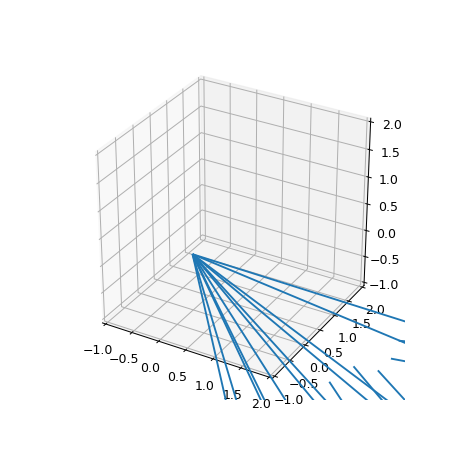

[ 0.62089757 -0.69394699 -0.36458713]
[ 0.65801273 -0.63934561 -0.39781457]
[ 0.74321576 -0.55610293 -0.37199444]
[ 0.88482051 -0.39724185 -0.24349861]
[ 0.9346882  -0.2767988  -0.22302555]
[ 0.98406782  0.13599844 -0.1145205 ]
[ 0.73321539 -0.43875117 -0.51951189]
[ 0.79653517 -0.3757863  -0.4736205 ]
[ 0.85392746 -0.27514225 -0.44170651]
[ 0.9279038  -0.05841677 -0.36821463]
[ 0.9326255   0.22196164 -0.28450432]


In [161]:
plot_directional_vectors(z_vectors)

In [162]:
shelf_plane_norm = z_vectors[IOPOTS]

In [118]:
def calculate_poi_new(n_vector, i_vector, dist_estimate):
    """
    Finds the point of intersection of a vector on the shelf plane.
    
    n_vector is shelf plane vector i.e. normal to the shelf plane
    i_vector is intersecting vector
    dist_estimate is estimate of shelf distance from person
    
    Notation from http://www.ambrsoft.com/TrigoCalc/Plan3D/PlaneLineIntersection_.htm
    """
    p_vector = n_vector + dist_estimate
    t = -(np.dot(n_vector, p_vector) + dist_estimate) / float(np.dot(n_vector, i_vector))  
    return i_vector * t

In [175]:
coordinates = []

for i in range(0, len(z_vectors)):
    coordinates.append(calculate_poi_new(shelf_plane_norm, z_vectors[i], DIST_ESTIMATE))

In [176]:
coordinates

[array([-5149.25379724,  5755.07028613,  3023.60931571]),
 array([-5404.38339394,  5251.06682241,  3267.32657909]),
 array([-6058.83154437,  4533.4533618 ,  3032.56707506]),
 array([-7443.21459268,  3341.6453329 ,  2048.33902883]),
 array([-8179.48983787,  2422.27617894,  1951.70456307]),
 array([-11487.56531016,  -1587.58465317,   1336.86079976]),
 array([-6085.73267886,  3641.66156272,  4311.98051962]),
 array([-6645.29605859,  3135.09220529,  3951.2987366 ]),
 array([-7312.58144615,  2356.17216421,  3782.54003686]),
 array([-8805.15722553,   554.33422482,  3494.09894748]),
 array([-11254.56185171,  -2678.54675075,   3433.28746915])]

In [177]:
from mpl_toolkits.mplot3d import Axes3D

def plot_poi(p_norm, coordinates):
    """
    Plots the points of intersection onto the shelf plane given
    the equation of the plane (ax + by + cz + d = 0) and the
    coordinates on the plane where the gaze intersected.
    
    p_norm     - plane norm aka n_vector aka shelf_plane_norm
    dist_est   - distance estimate of shelf from person
    coordinate - list of POI
    """
    fig = plt.figure(figsize=(5, 5))
    ax = fig.gca(projection='3d')
#     ax.hold(True)
    
    lim_begin, lim_end = -140000, 140000
    
    # create x,y
    #xx, yy = np.meshgrid(range(-1000, 1000), range(-1000, 1000))
    interval = range(lim_begin, lim_end, 10000)
    xx, yy = np.meshgrid(interval, interval)
    
    # calculate corresponding z
    z = -1 * (p_norm[0] * xx + p_norm[1] * yy + DIST_ESTIMATE) / float(p_norm[2])
    #z = -1 * (p_norm[0] * xx + p_norm[1] * yy) / float(p_norm[2])
    
    z += DIST_ESTIMATE
    
    ax.plot_surface(xx, yy, z, alpha=0.5)
    ax.set_xlim(lim_begin, lim_end)
    ax.set_xlabel("x")
    
    ax.set_ylim(lim_begin, lim_end)
    ax.set_ylabel("y")
    
    ax.set_zlim(lim_begin, lim_end)
    ax.set_zlabel("z")
    
    for coord in coordinates:
        ax.scatter(coord[0], coord[1], coord[2])
  
    plt.show()

In [178]:
coordinates, DIST_ESTIMATE, min([c.min() for c in coordinates]),  max([c.max() for c in coordinates])

([array([-5149.25379724,  5755.07028613,  3023.60931571]),
  array([-5404.38339394,  5251.06682241,  3267.32657909]),
  array([-6058.83154437,  4533.4533618 ,  3032.56707506]),
  array([-7443.21459268,  3341.6453329 ,  2048.33902883]),
  array([-8179.48983787,  2422.27617894,  1951.70456307]),
  array([-11487.56531016,  -1587.58465317,   1336.86079976]),
  array([-6085.73267886,  3641.66156272,  4311.98051962]),
  array([-6645.29605859,  3135.09220529,  3951.2987366 ]),
  array([-7312.58144615,  2356.17216421,  3782.54003686]),
  array([-8805.15722553,   554.33422482,  3494.09894748]),
  array([-11254.56185171,  -2678.54675075,   3433.28746915])],
 10000,
 -11487.565310159287,
 5755.070286125258)

<IPython.core.display.Javascript object>


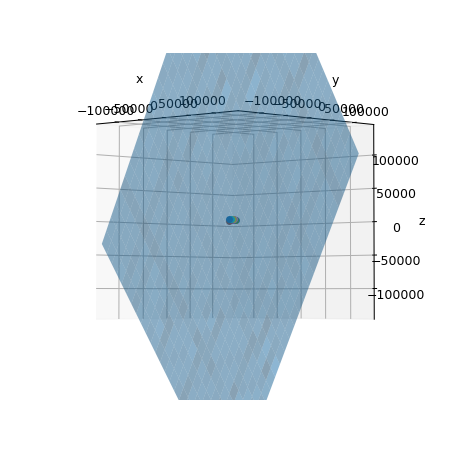

In [179]:
plot_poi(shelf_plane_norm, coordinates)

In [180]:
np.savetxt('data_for_demo_v2/shelf_plane_norm.txt', shelf_plane_norm)

In [181]:
np.savetxt('data_for_demo_v2/product_plane_coords.txt', coordinates)

In [182]:
np.savetxt('data_for_demo_v2/product_vectors.txt', z_vectors)